In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
# 데이터 로드
file = '../data/mydata2_final.csv'
data = pd.read_csv(file)
data

,c_temp_pv,k_rpm_pv,n_temp_pv,scale_pv,s_temp_pv
0,69.6,189,67.2,3.01,67.1
1,69.8,189,67.2,3.01,67.0
2,69.7,189,67.9,3.08,65.9
3,69.7,189,67.8,3.08,65.9
4,69.7,189,67.8,3.08,65.9
...,...,...,...,...,...
193963,69.6,184,66.5,0.00,67.6
193964,69.5,184,66.6,0.00,67.7
193965,69.4,184,66.5,0.00,67.7
193966,69.4,184,66.4,0.00,67.8


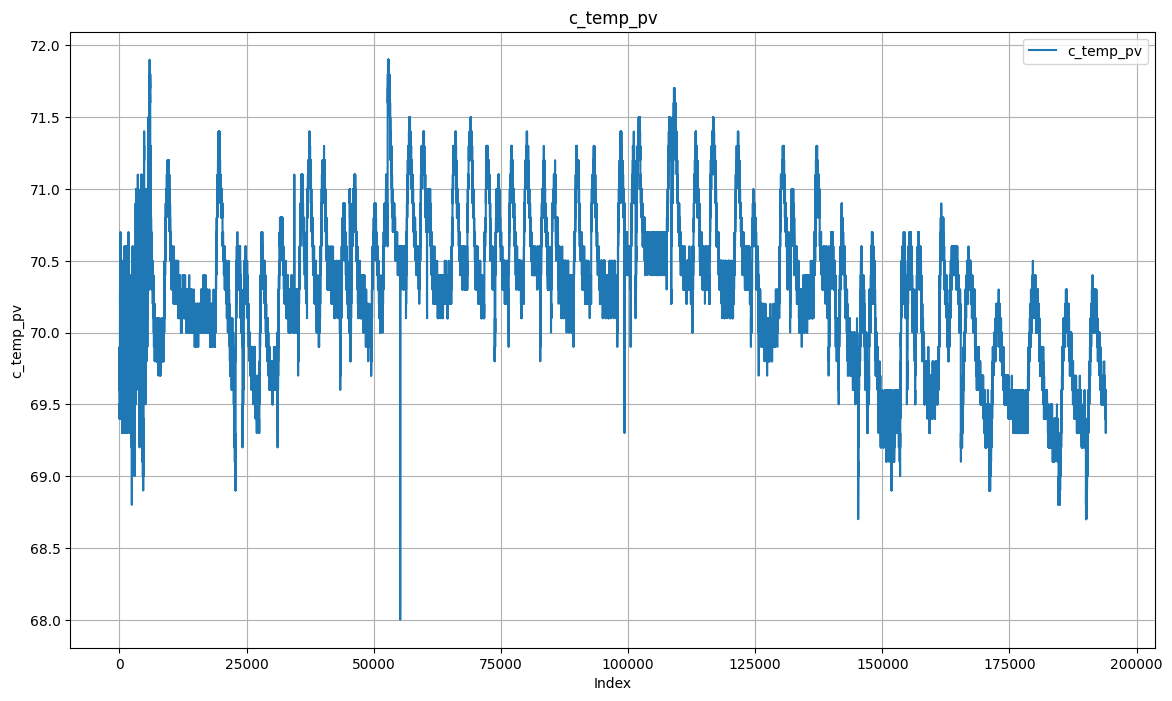

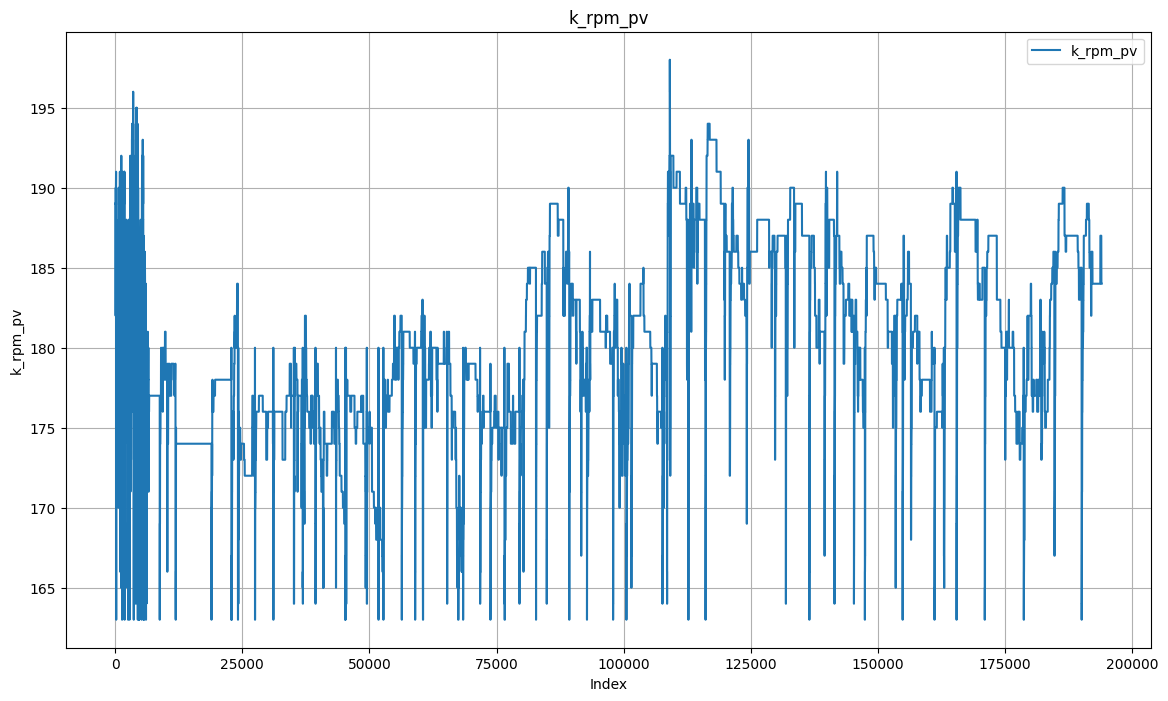

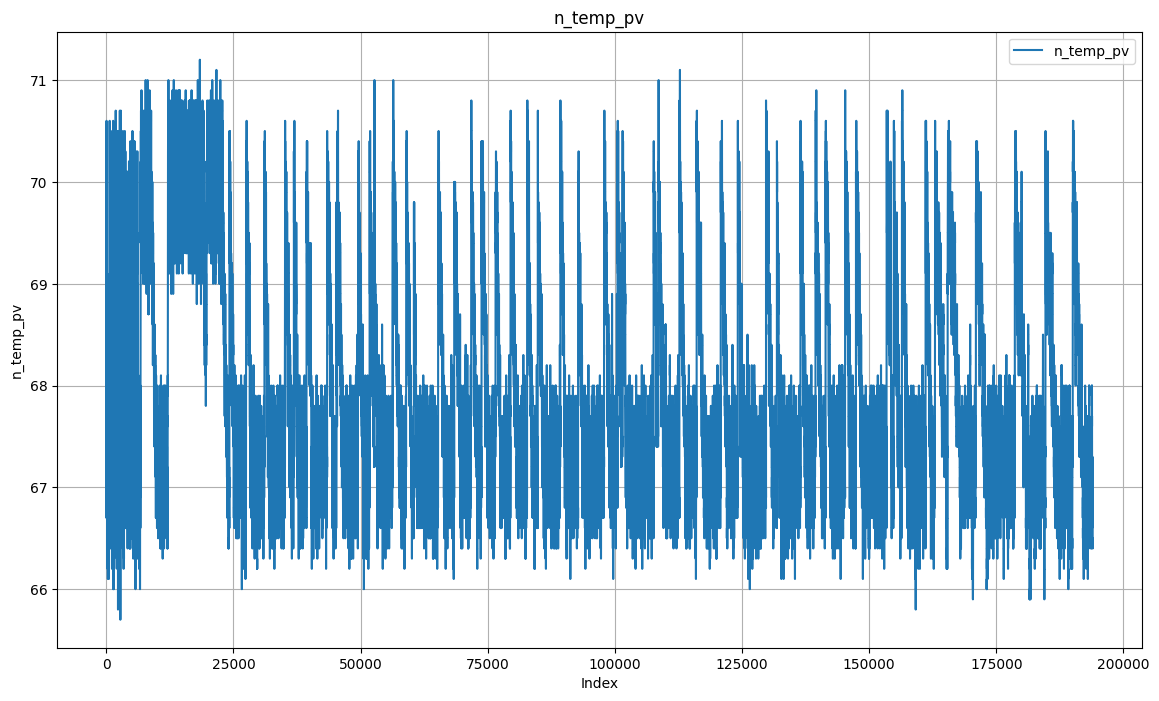

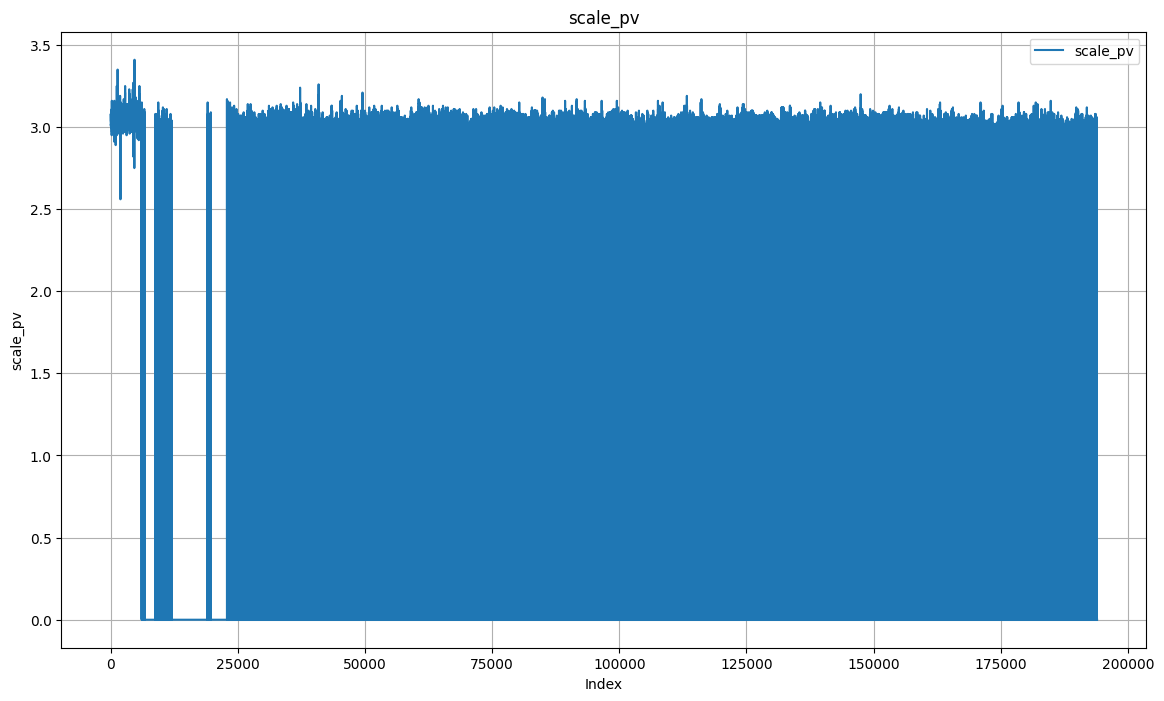

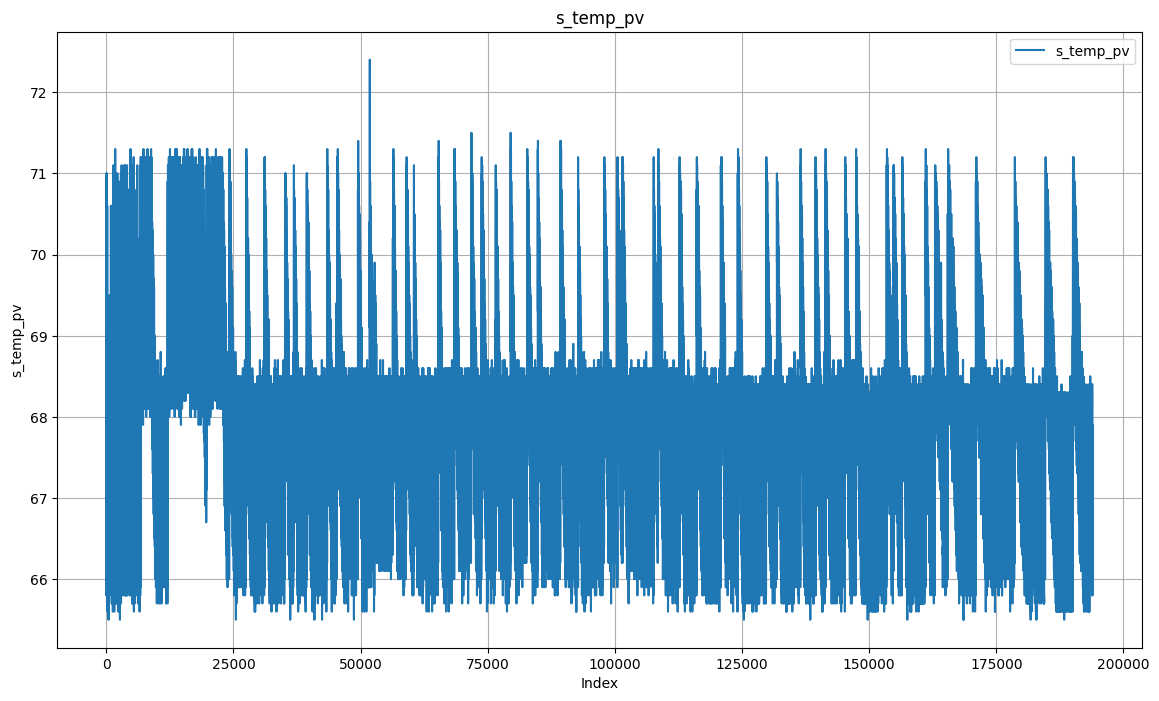

In [3]:
# 각 컬럼별 그래프 그리기
for column in data.columns:
    plt.figure(figsize=(14, 8))
    plt.plot(data.index, data[column], label=column)
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.title(f'{column}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
# scale_pv가 0이 아닌 데이터와 0인 데이터로 분리
non_zero_data = data[data['scale_pv'] != 0]
zero_data = data[data['scale_pv'] == 0]

In [5]:
# KNN을 위한 피처와 타겟 설정 (scale_pv가 0이 아닌 데이터)
features = non_zero_data.drop(columns=['scale_pv'])
target = non_zero_data['scale_pv']

In [6]:
# 데이터 스케일링
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_zero_features = scaler.transform(zero_data.drop(columns=['scale_pv']))

In [7]:
# KNN 모델 적합
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(scaled_features, target)

KNeighborsRegressor(n_neighbors=10)

In [8]:
# 미측정 데이터에 대한 예측값 생성 (scale_pv가 0인 데이터)
predicted_scale_pv = knn.predict(scaled_zero_features)

In [9]:
# 예측값을 미측정 데이터에 추가
zero_data.loc[:, 'scale_pv'] = predicted_scale_pv

In [10]:
# 원본 데이터와 새로 생성된 데이터를 결합하여 인덱스 기준으로 재정렬
augmented_data = pd.concat([non_zero_data, zero_data]).sort_index()
augmented_data = augmented_data.loc[data.index]

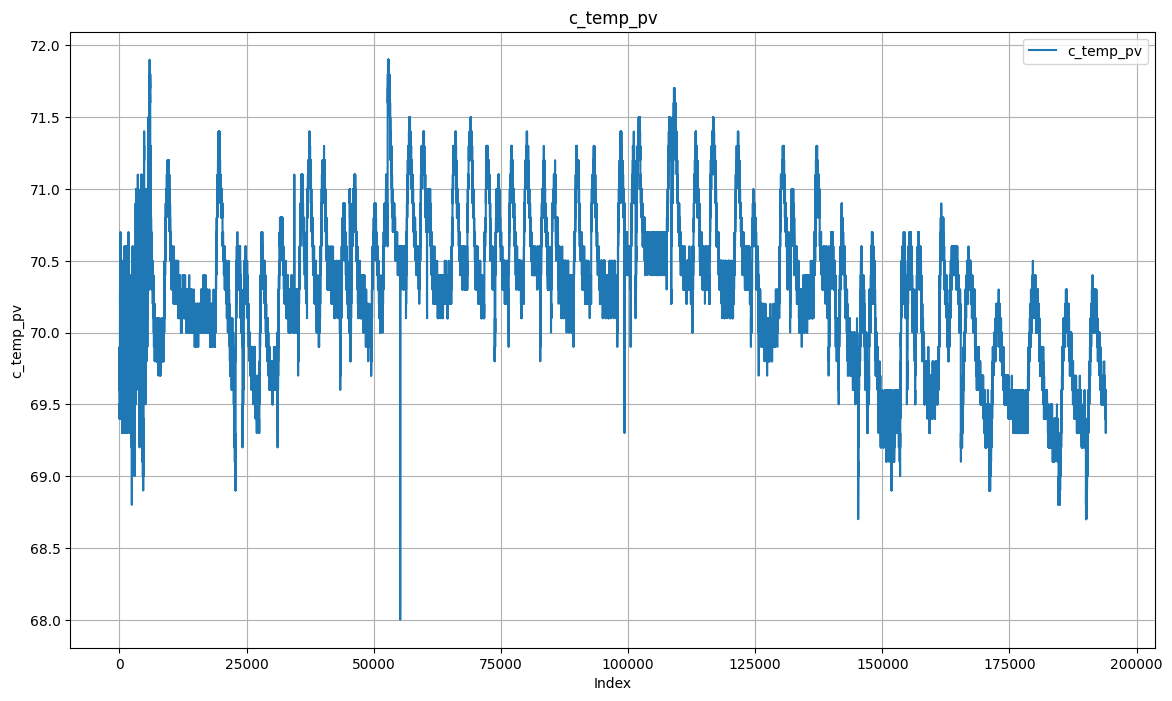

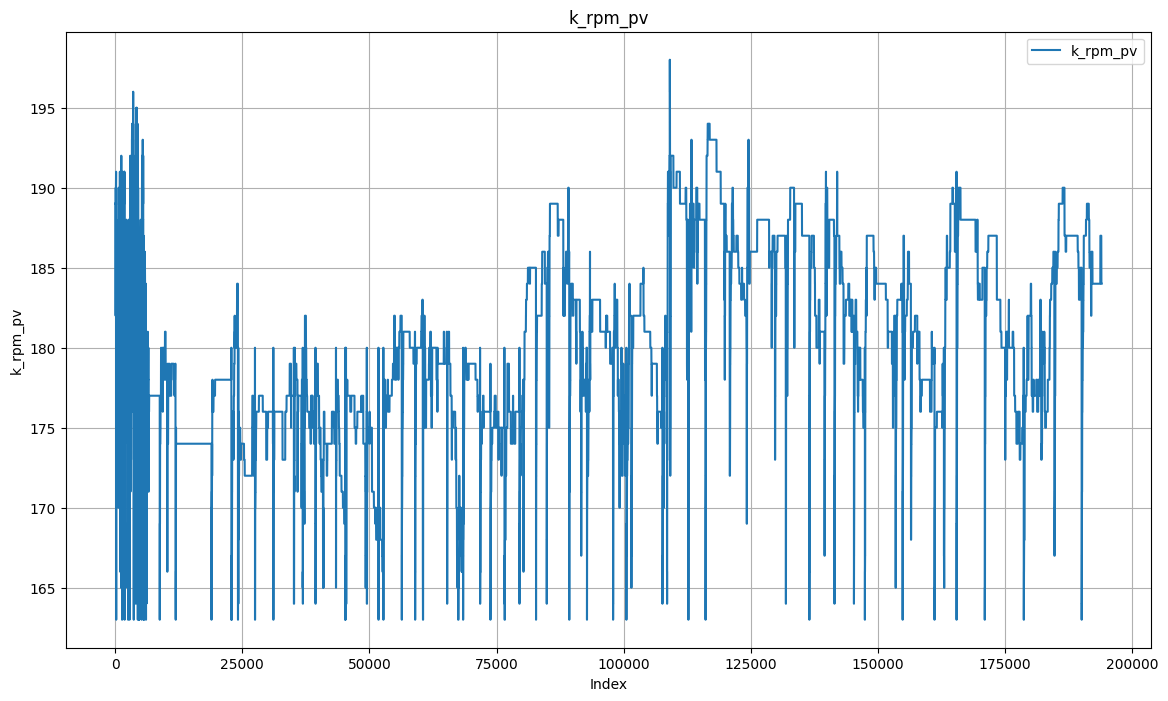

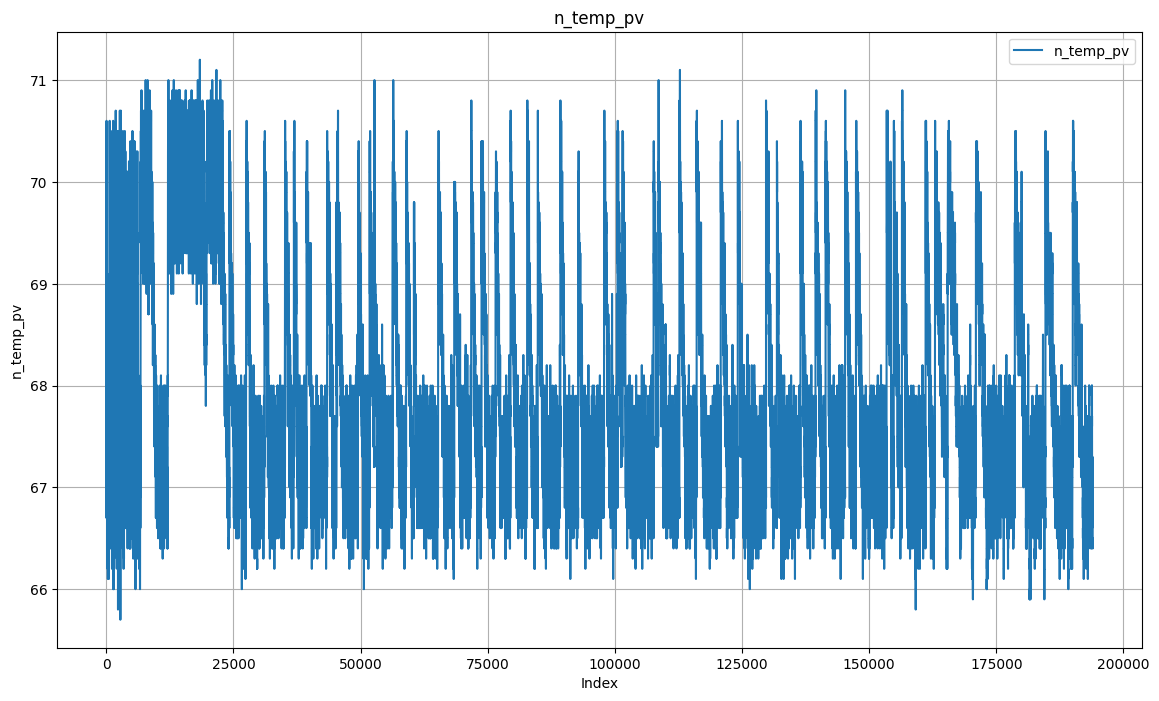

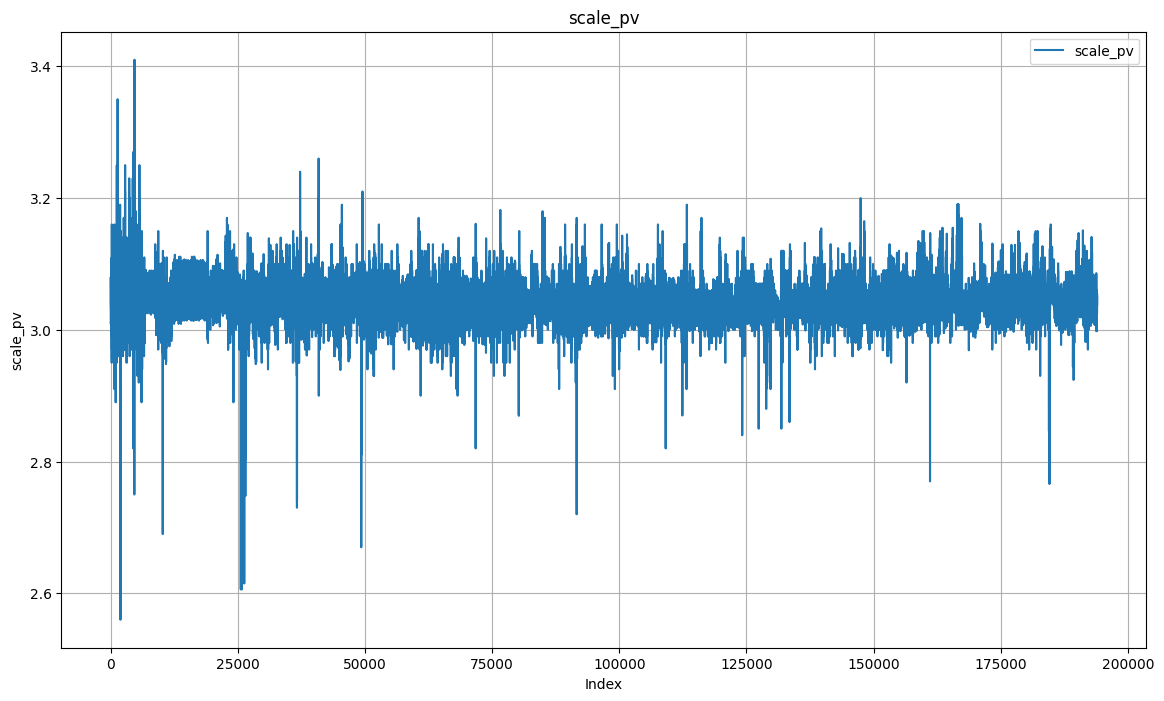

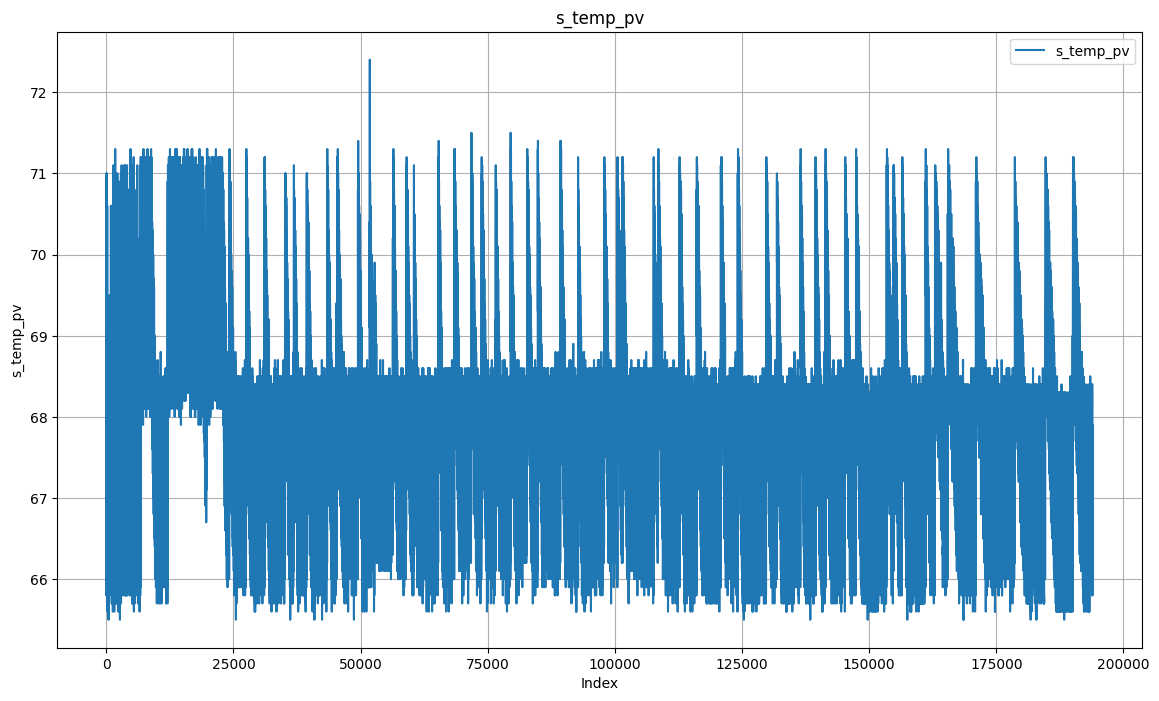

In [11]:
# 각 컬럼별 그래프 그리기
for column in augmented_data.columns:
    plt.figure(figsize=(14, 8))
    plt.plot(augmented_data.index, augmented_data[column], label=column)
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.title(f'{column}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
# 데이터의 순서가 유지되었는지 확인
original_order = data.index
augmented_order = augmented_data.index

# 순서가 같은지 비교
order_is_same = np.array_equal(original_order, augmented_order)

print("Original and augmented data order is the same:", order_is_same)

Original and augmented data order is the same: True


In [13]:
# 중복값 제거
augmented_data.drop_duplicates(inplace=True)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [15]:
# 피처와 타겟 분리
X = augmented_data.drop(columns=['scale_pv'])
y = augmented_data['scale_pv']

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# 모델 학습 및 평가 함수
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, scaler):
    model.fit(X_train, y_train)
    y_train_pred_scaled = model.predict(X_train)
    y_test_pred_scaled = model.predict(X_test)
    
    # 역스케일링
    y_train_pred = scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1))
    y_test_pred = scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1))
    y_train_original = scaler.inverse_transform(y_train.values.reshape(-1, 1))
    y_test_original = scaler.inverse_transform(y_test.values.reshape(-1, 1))
    
    train_mae = mean_absolute_error(y_train_original, y_train_pred)
    test_mae = mean_absolute_error(y_test_original, y_test_pred)
    train_mape = mean_absolute_percentage_error(y_train_original, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test_original, y_test_pred)
    
    return train_mae, test_mae, train_mape, test_mape, y_train_pred, y_test_pred

In [17]:
# 역스케일링
target_scaler = StandardScaler()
target_scaler.fit(target.values.reshape(-1, 1))

StandardScaler()

In [18]:
from sklearn.linear_model import Lasso, Ridge
# # Lasso Regression
# lasso_model = Lasso(alpha=0.1)
# lasso_train_mae, lasso_test_mae, lasso_train_mape, lasso_test_mape, lasso_y_train_pred, lasso_y_test_pred = train_and_evaluate_model(lasso_model, X_train, X_test, y_train, y_test, target_scaler)

# # Ridge Regression
# ridge_model = Ridge(alpha=1.0)
# ridge_train_mae, ridge_test_mae, ridge_train_mape, ridge_test_mape, ridge_y_train_pred, ridge_y_test_pred = train_and_evaluate_model(ridge_model, X_train, X_test, y_train, y_test, target_scaler)

# Multiple Regression
lr_model = LinearRegression()
lr_train_mae, lr_test_mae, lr_train_mape, lr_test_mape, lr_y_train_pred, lr_y_test_pred = train_and_evaluate_model(lr_model, X_train, X_test, y_train, y_test, target_scaler)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_train_mae, rf_test_mae, rf_train_mape, rf_test_mape, rf_y_train_pred, rf_y_test_pred = train_and_evaluate_model(rf_model, X_train, X_test, y_train, y_test, target_scaler)

# LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb_train_mae, lgb_test_mae, lgb_train_mape, lgb_test_mape, lgb_y_train_pred, lgb_y_test_pred = train_and_evaluate_model(lgb_model, X_train, X_test, y_train, y_test, target_scaler)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 103004, number of used features: 4
[LightGBM] [Info] Start training from score 3.042988


In [19]:
# 결과 출력
# print(f"Lasso Regression - Train MAE: {lasso_train_mae}, Train MAPE: {lasso_train_mape*100}")
# print(f"Lasso Regression - Test MAE: {lasso_test_mae}, Test MAPE: {lasso_test_mape*100}")
# print()
# print(f"Ridge Regression - Train MAE: {ridge_train_mae}, Train MAPE: {ridge_train_mape*100}")
# print(f"Ridge Regression - Test MAE: {ridge_test_mae}, Test MAPE: {ridge_test_mape*100}")
# 결과 출력
print(f"Linear Regression - Train MAE: {lr_train_mae}, Train MAPE: {lr_train_mape*100}")
print(f"Linear Regression - Test MAE: {lr_test_mae}, Test MAPE: {lr_test_mape*100}")
print()
print(f"Random Forest - Train MAE: {rf_train_mae}, Train MAPE: {rf_train_mape*100}")
print(f"Random Forest - Test MAE: {rf_test_mae}, Test MAPE: {rf_test_mape*100}")
print()
print(f"LightGBM - Train MAE: {lgb_train_mae}, Train MAPE: {lgb_train_mape*100}")
print(f"LightGBM - Test MAE: {lgb_test_mae}, Test MAPE: {lgb_test_mape*100}")

Linear Regression - Train MAE: 0.0005966546560440541, Train MAPE: 0.01893030573511891
Linear Regression - Test MAE: 0.0005914186866800776, Test MAPE: 0.018763765599087552

Random Forest - Train MAE: 0.00017786994794854593, Train MAPE: 0.005643357350770288
Random Forest - Test MAE: 0.0003798845588002245, Test MAPE: 0.012052489177245143

LightGBM - Train MAE: 0.0005026233173996973, Train MAPE: 0.015946624900180676
LightGBM - Test MAE: 0.0005059680618125167, Test MAPE: 0.016052509584770225


In [20]:
test_file = '../data/test.csv'
test_data = pd.read_csv(test_file)
test_data

,c_temp_pv,k_rpm_pv,n_temp_pv,scale_pv,s_temp_pv
0,69.4,180,69.5,0.0,70.3
1,69.4,179,69.4,0.0,70.4
2,69.5,176,69.4,0.0,70.6
3,69.4,173,69.6,0.0,70.7
4,69.5,173,69.4,0.0,70.8
...,...,...,...,...,...
29404,69.7,191,67.6,0.0,67.3
29405,69.8,191,67.5,0.0,67.0
29406,69.7,191,67.4,0.0,66.8
29407,69.7,191,67.3,0.0,66.7


In [22]:
# scale_pv 값이 2초과 4미만인 데이터 선택
test_data_filtered = test_data[(test_data['scale_pv'] > 2) & (test_data['scale_pv'] < 4)]
print(test_data_filtered.shape)
test_data_filtered

(1395, 5)


In [ ]:

# 피처와 타겟 분리
X_test_final = test_data_filtered.drop(columns=['scale_pv'])
y_test_final = test_data_filtered['scale_pv']

# 최종 테스트 데이터 예측 및 평가
def final_evaluate_model(model, X_test, y_test, scaler):
    y_test_pred_scaled = model.predict(X_test)
    
    # 역스케일링
    y_test_pred = scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1))
    y_test_original = scaler.inverse_transform(y_test.values.reshape(-1, 1))
    
    test_mae = mean_absolute_error(y_test_original, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test_original, y_test_pred)
    
    return test_mae, test_mape, y_test_pred

# 최종 평가 결과
#lasso_test_mae_final, lasso_test_mape_final, lasso_y_test_pred_final = final_evaluate_model(lasso_model, X_test_final, y_test_final, target_scaler)
#ridge_test_mae_final, ridge_test_mape_final, ridge_y_test_pred_final = final_evaluate_model(ridge_model, X_test_final, y_test_final, target_scaler)
lr_test_mae_final, lr_test_mape_final, lr_y_test_pred_final = final_evaluate_model(lr_model, X_test_final, y_test_final, target_scaler)
rf_test_mae_final, rf_test_mape_final, rf_y_test_pred_final = final_evaluate_model(rf_model, X_test_final, y_test_final, target_scaler)
lgb_test_mae_final, lgb_test_mape_final, lgb_y_test_pred_final = final_evaluate_model(lgb_model, X_test_final, y_test_final, target_scaler)

#print(f"Final Test - Lasso Regression MAE: {lasso_test_mae_final}, MAPE: {lasso_test_mape_final*100}")
#print(f"Final Test - Ridge Regression MAE: {ridge_test_mae_final}, MAPE: {ridge_test_mape_final*100}")
print(f"Final Test - Linear Regression MAE: {lr_test_mae_final}, MAPE: {lr_test_mape_final*100}")
print(f"Final Test - Random Forest MAE: {rf_test_mae_final}, MAPE: {rf_test_mape_final*100}")
print(f"Final Test - LightGBM MAE: {lgb_test_mae_final}, MAPE: {lgb_test_mape_final*100}")